<h2><center> Introduction to PyTorch</center> </h2>

# 1. Setting Up PyTorch

In [1]:
import torch  # now import the pytorch module
from torch import nn
import numpy as np 
print(torch.__version__)  # check the version

1.10.2


## 2. Linear regression with PyTorch

Suppose we are given input and output pairs $(x_1,y_1), ..., (x_n,y_n)$, where each $x_i\in \mathbb{R}^d$ is a $d$ dimensional feature vector and $y_i$ is the output. We consider the following linear regression model

$$y = w^T x + b$$

where $w,b$ are the model parameters. The loss function is the squared loss

$$\ell(w,b) = \frac{1}{n} \sum_{i=1}^n (y_i - w^T x_i)^2$$

The training process is to minimize the the loss function via gradient descent. 


### Key steps in pytorch machine learning programming

- Step 1: Build the model: The model is a subclass of nn.Module. It stores the model parameters, and also specifies how to calculate the model output given the model input

- Step 2: Prepare the training and testing data 

- Step 3: Conduct training loops

## 2.1 Build Linear Regression Model

In [2]:
from torch import nn

class MyLinearRegressionModel(nn.Module): 
    def __init__(self,d): # d is the dimension of the input
        super(MyLinearRegressionModel,self).__init__()   # call the init function of super class
        # we usually create variables for all our model parameters (w and b in our case) in __init__ and give them initial values. 
        # need to create them as nn.Parameter so that the model knows it is an parameter that needs to be trained
        self.w = nn.Parameter(torch.zeros(1,d, dtype=torch.float)) 
        self.b = nn.Parameter(torch.zeros(1,dtype=torch.float))
    def forward(self,x):
        # The main purpose of the forward function is to specify given input x, how the output is calculated. 
        return torch.inner(x,self.w) + self.b
    
# Let's check out our model 

mymodel = MyLinearRegressionModel(1) # creating a model instance with input dimension 1
print(mymodel.w)
print(mymodel.b)



Parameter containing:
tensor([[0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [3]:
x = torch.tensor(2)
print(mymodel(x)) # we should expect this to be w*x+b = 0*2+0 = 0 (recall that w is initialized to be 0, and b is 0)


tensor([[0.]], grad_fn=<AddBackward0>)


## 2.2 Prepare Training Data

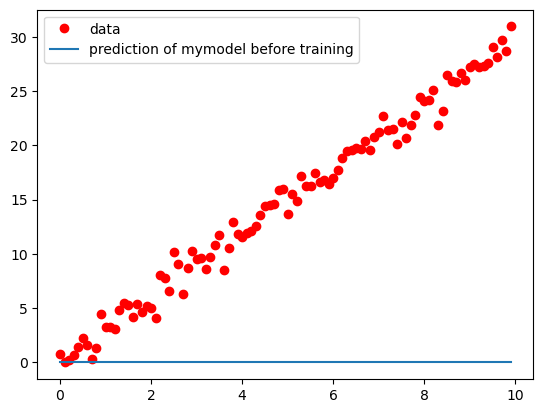

In [4]:
# Now let's create some simple synthetic data

import matplotlib.pyplot as plt

x = torch.arange(0,10,.1,dtype=torch.float) 
x = x[:,None]
y = x*3+torch.randn(x.shape)

prediction = mymodel(x).detach().numpy()
plt.plot(x,y,'ro')
plt.plot(x,prediction)
plt.legend(['data','prediction of mymodel before training'])



## 2.3 Performing Gradient Descent

### Forward Pass

The first step to calculate gradient is to do a "fowrad pass", which means compute the loss from the current parameters and the training data. 

In [5]:
# Let's try to calculate the gradient
# Forward calculates the Loss

prediction = mymodel(x) 

loss = torch.mean((prediction - y)**2)

print(loss)

tensor(292.7288, grad_fn=<MeanBackward0>)


### Backward

Before we talk about backward, let's see what the gradients are now. They are stored in `.grad` attributes in the two model parameters. They should be `None` as we haven't computed it yet. 

In [6]:
# Backward calculates the gradient
# Now do loss.backward()  then you can iteratively compute the gradient and compute the descent

print(mymodel.w.grad,mymodel.b.grad)

None None


The backward function computes the gradient, and you can check the gradient values. 

In [7]:
loss.backward()
print(mymodel.w.grad,mymodel.b.grad)

tensor([[-195.7584]]) tensor([-29.5983])


### Training loop 

Let's now write a training loop for gradient descent! The training procedure is a loop of multiple gradient steps. In each training step in the training loop,

- First the prediction is computed based on the input variable of the training data set. 
- Then, the prediction, together with the training output, is used to compute the loss.
- Then, we run the optimizer.zero_grad(), which clears the gradient computed from the previous loop. 
- Then, we run loss.backward() which calculates the gradient of the loss w.r.t. the parameters
- Finally, optimizer.step() conducts a gradient step


In [8]:
# Now let's do the training!

maxIter = 100

mymodel = MyLinearRegressionModel(1)

# this creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel. In this case we're optimizing w,b
optimizer = torch.optim.SGD(mymodel.parameters(), lr = 1e-3)  # lr = learning rate, so you set the learning rate

for _ in range(maxIter):

    # pass input data to get the prediction outputs by the current model
    prediction = mymodel(x)

    # compare prediction and the actual output and compute the loss
    loss = torch.mean((prediction - y)**2)

    # compute the gradient
    optimizer.zero_grad() # zero it out because we only want the gradient descent rather than the sum of all of the gradients
    loss.backward()

    # update parameters
    optimizer.step()



Parameter containing:
tensor([[2.9131]], requires_grad=True) Parameter containing:
tensor([0.4291], requires_grad=True)


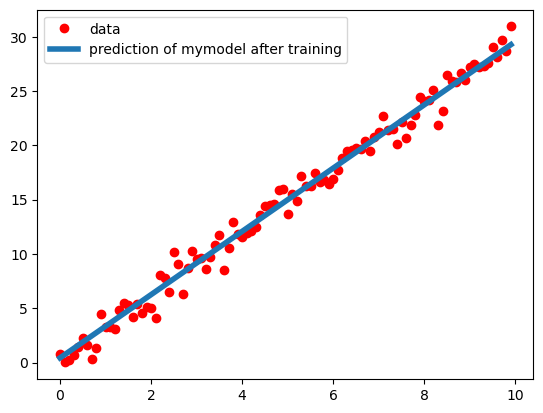

In [9]:
# let's see how the model looks like!

print(mymodel.w,mymodel.b)

prediction = mymodel(x).detach().numpy()
plt.plot(x,y,'ro')
plt.plot(x,prediction,linewidth = 4)
plt.legend(['data','prediction of mymodel after training'])



## 2.4 Visualizing Gradient Descent

In [10]:
import io
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

mymodel = MyLinearRegressionModel(1) # creating a model instance with input dimension 1
lr = 3e-2
optimizer = torch.optim.SGD(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel


frames = []

losses = []

maxIter = 100

for i in range(maxIter):

    # pass input data to get the prediction outputs by the current model
    prediction = mymodel(x)

    # compare prediction and the actual output and compute the loss
    loss = torch.mean((prediction - y)**2)

    # compute the gradient
    optimizer.zero_grad()
    loss.backward()

    # update parameters
    optimizer.step()
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    canvas = FigureCanvas(fig)
    ax[0].plot(x,y,'ro')
    ax[0].plot(x,prediction.detach(),linewidth = 2)
    ax[0].legend(['data','prediction of mymodel'],loc = 'upper left')
    ax[0].set_title(f"Learning rate = {lr}, Iteration {i}")
    ax[0].set_xlim((0,10))
    ax[0].set_ylim((0,30))

    losses.append(loss.detach().numpy())
    ax[1].plot(np.arange(i+1),np.array(losses).squeeze(),linewidth=2 )
    ax[1].set_xlim((0,maxIter))
    ax[1].set_ylim((0,300))
    ax[1].set_title("Training loss")
    canvas.draw()       # draw the canvas, cache the renderer

    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')

    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    frames.append(image)
    plt.close(fig)


print("Saving GIF file")
with imageio.get_writer("GD.gif", mode="I") as writer:
    for frame in frames:
        writer.append_data(frame)



Saving GIF file
